In [28]:
import os
import json
import math
from datetime import datetime
from pathlib import Path

## Environment
import psycopg2
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt


## Core Scientific Stack
import numpy as np

## Machine Learning / Preprocessing (scikit-learn)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

## Optimization & Persistence
import optuna
import joblib
import contextlib
import sys
import io
import logging
import time

print("All imports loaded successfully")

# Configuration flags
FORCE_RETRAIN = False  # Set to False to load pretrained models when available
# Connect to database and load data
load_dotenv(override=True)

# Setup model directory (handle notebook environment where __file__ is undefined)
try:
    PROJECT_ROOT = Path(__file__).resolve().parent
except NameError:
    # Fallback: assume notebook is inside src; go up one directory if so
    cwd = Path.cwd().resolve()
    if (cwd / 'supervised.ipynb').exists() or (cwd / 'unsupervised.ipynb').exists():
        PROJECT_ROOT = cwd
    else:
        for parent in cwd.parents:
            if (parent / 'requirements.txt').exists() or (parent / 'README.md').exists():
                PROJECT_ROOT = parent / 'src'
                break
        else:
            PROJECT_ROOT = cwd  # final fallback

MODEL_DIR = (PROJECT_ROOT / '..' / 'unsupervised').resolve()
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"Models will be saved to: {MODEL_DIR}")

def save_model(model, name: str, extra: dict | None = None):
    """Utility to persist models and optional metadata alongside them.
    Saves model as joblib plus a companion JSON with metadata/hyperparams."""
    timestamp = datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')
    base_name = f"{name}_{timestamp}"
    model_path = MODEL_DIR / f"{base_name}.joblib"
    meta_path = MODEL_DIR / f"{base_name}.json"
    joblib.dump(model, model_path)
    meta = {'model_name': name, 'saved_utc': timestamp}
    if extra:
        meta.update(extra)
    with open(meta_path, 'w') as f:
        json.dump(meta, f, indent=2)
    print(f"Saved model -> {model_path.name}; metadata -> {meta_path.name}")


def load_pretrained_model(name: str):
    """Load a pretrained model if it exists and FORCE_RETRAIN is False.
    
    Returns:
        tuple: (model, metadata_dict) if found, (None, None) if not found or FORCE_RETRAIN=True
    """
    if FORCE_RETRAIN:
        print(f"FORCE_RETRAIN=True, skipping pretrained {name} model loading")
        return None, None
    
    # Find the most recent model file for this name
    model_files = list(MODEL_DIR.glob(f"{name}_*.joblib"))
    if not model_files:
        print(f"No pretrained {name} model found")
        return None, None
    
    # Get the most recent model (by timestamp in filename)
    model_files.sort(key=lambda x: x.stem.split('_')[-1], reverse=True)
    latest_model_path = model_files[0]
    meta_path = latest_model_path.with_suffix('.json')
    
    if not meta_path.exists():
        print(f"Metadata file missing for {name} model, skipping load")
        return None, None
    
    try:
        model = joblib.load(latest_model_path)
        with open(meta_path, 'r') as f:
            metadata = json.load(f)
        print(f"Loaded pretrained {name} model from {latest_model_path.name}")
        return model, metadata
    except Exception as e:
        print(f"Error loading pretrained {name} model: {e}")
        return None, None


# Initialize model variables (only set to None if not already defined)
if 'pca_optimal' not in globals():
    pca_optimal = None
if 'kmeans_best' not in globals():
    kmeans_best = None
if 'gmm_best' not in globals():
    gmm_best = None

# Model loading patterns
MODEL_GLOB_PATTERNS = {
    'pca_optimal': 'pca_optimal_*.joblib',
    'kmeans_best': 'kmeans_best_*.joblib',
    'gmm_best': 'gmm_best_*.joblib'
}

# Attempt to load pretrained models
loaded_flags = {}
for var, pattern in MODEL_GLOB_PATTERNS.items():
    if globals().get(var) is not None:
        loaded_flags[var] = 'pre-existing'
        continue
    matches = list(MODEL_DIR.glob(pattern))
    if not matches:
        loaded_flags[var] = 'not found'
        continue
    # Sort by modification time to get the truly latest file
    latest = max(matches, key=lambda p: p.stat().st_mtime)
    try:
        globals()[var] = joblib.load(latest)
        meta_file = latest.with_suffix('.json')
        if meta_file.exists():
            with open(meta_file) as f:
                globals()[f"{var}_meta"] = json.load(f)
        # Show the actual file that was loaded
        loaded_flags[var] = f"✓ {latest.name}"
        print(f"  {var}: {latest}")
    except Exception as e:
        loaded_flags[var] = f"failed: {e}"
        globals()[var] = None

print("\nAuto-load status:")
for k, v in loaded_flags.items():
    print(f"  {k}: {v}")
print(f"\nFORCE_RETRAIN = {FORCE_RETRAIN}")


# Database connection parameters
db_params = {
    "host": os.getenv("LOCAL_HOST"),
    "user": os.getenv("LOCAL_USER"),
    "password": os.getenv("LOCAL_PW"),
    "port": os.getenv("LOCAL_PORT"),
    "dbname": os.getenv("LOCAL_DB")
}

try:
    conn = psycopg2.connect(**db_params)
    print("Database connection successful")
    sql_query = "SELECT * FROM dev.base_data;"
    df = pd.read_sql_query(sql_query, conn)
    conn.close()
    print("Golden data loaded into DataFrame:")
    print(df.info())
except Exception as e:
    print(f"An error occurred: {e}")

All imports loaded successfully
Models will be saved to: D:\docs\MADS\696-Milestone 2\unsupervised

Auto-load status:
  pca_optimal: pre-existing
  kmeans_best: pre-existing
  gmm_best: pre-existing

FORCE_RETRAIN = False
Database connection successful


C:\Users\Leo\AppData\Local\Temp\ipykernel_11680\3777485148.py:172: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


Golden data loaded into DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23038 entries, 0 to 23037
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   school_name             23038 non-null  object 
 1   school_type             23038 non-null  object 
 2   teachers_fte            22550 non-null  float64
 3   enrollment              22863 non-null  float64
 4   grade_eight_enrollment  21613 non-null  float64
 5   math_counts             22507 non-null  float64
 6   math_high_pct           22507 non-null  float64
 7   read_counts             22386 non-null  float64
 8   read_high_pct           22386 non-null  float64
 9   pct_hhi_150k_200k       23038 non-null  float64
 10  pct_hhi_220k_plus       23038 non-null  float64
 11  avg_natwalkind          23038 non-null  float64
 12  total_10_14             23038 non-null  int64  
 13  pct_10_14               23038 non-null  int64  
 14  pct

## 1. Data Overview & Preprocessing



In [19]:
# Basic shape & preview
print(f"DataFrame shape: {df.shape}")
display(df.head())

df_numeric = df.select_dtypes(include=['int64','float64']).copy()
print(f"Numeric subset shape: {df_numeric.shape}")
missing_pct = df_numeric.isna().mean().sort_values(ascending=False)
print("Missing value percentage (top 15):")
display(missing_pct.head(15))

DataFrame shape: (23038, 18)


,school_name,school_type,teachers_fte,enrollment,grade_eight_enrollment,math_counts,math_high_pct,read_counts,read_high_pct,pct_hhi_150k_200k,pct_hhi_220k_plus,avg_natwalkind,total_10_14,pct_10_14,pct_female_10_14,total_pop,schools_in_zip,dup_rank
0,1 LT Charles W. Whitcomb School,1,93.0,1077.0,370.0,71.0,9.0,71.0,5.0,4.57,5.03,12.317521,2081,0,0.0,41505,2,1
1,100 Academy of Engineering and Technology MS,1,NaN,147.0,47.0,5.0,49.0,7.0,49.0,2.01,0.75,12.120378,3841,0,0.0,47881,3,1
2,1R ELEMENTARY,1,12.0,191.0,25.0,9.0,79.0,9.0,59.0,2.33,1.34,8.287234,2008,0,0.0,25966,4,1
3,21st Century Charter Sch of Gary,1,96.0,1329.0,102.0,98.0,5.0,96.0,49.0,0.54,0.15,8.167196,528,0,0.0,6105,1,1
4,21st Century Cyber CS,1,72.0,1536.0,202.0,95.0,49.0,96.0,69.0,5.35,8.93,8.938298,2838,0,0.0,50510,4,1


Numeric subset shape: (23038, 16)
Missing value percentage (top 15):


grade_eight_enrollment    0.061854
read_counts               0.028301
read_high_pct             0.028301
math_counts               0.023049
math_high_pct             0.023049
teachers_fte              0.021182
enrollment                0.007596
pct_female_10_14          0.004384
pct_hhi_150k_200k         0.000000
pct_hhi_220k_plus         0.000000
avg_natwalkind            0.000000
total_10_14               0.000000
pct_10_14                 0.000000
total_pop                 0.000000
schools_in_zip            0.000000
dtype: float64

In [20]:
# Handle missing values: simple strategy (median). Could be enhanced later.

imputer = SimpleImputer(strategy='median')
scaled_features = imputer.fit_transform(df_numeric)
scaler = StandardScaler()
X = scaler.fit_transform(scaled_features)
print(f"Feature matrix ready. Shape: {X.shape}")

Feature matrix ready. Shape: (23038, 16)



## 2. Optimization Helpers (Optuna)
We define metric computation and a utility to optionally apply PCA inside each trial to reduce dimensionality (tuned as a hyperparameter).

In [21]:
# Ensure optuna is available (if running in an environment where pip install is allowed)


# Cache original data for reuse
X_full = X  # already scaled


def prepare_features(trial, X_input):
    """Optionally apply PCA controlled by trial hyperparameters."""
    use_pca = trial.suggest_categorical('use_pca', [True, False])
    if use_pca:
        # limit components between 2 and min(50, n_features)
        max_comp = min(50, X_input.shape[1])
        n_components = trial.suggest_int('pca_components', 2, max_comp)
        pca = PCA(n_components=n_components, random_state=42)
        X_red = pca.fit_transform(X_input)
        return X_red, pca
    return X_input, None


def compute_cluster_metrics(X_data, labels):
    # Guard for metrics requiring >1 cluster and fewer than n_samples clusters
    unique_labels = set(labels)
    if len(unique_labels) <= 1 or len(unique_labels) >= len(labels):
        return {
            'silhouette': float('nan'),
            'calinski_harabasz': float('nan'),
            'davies_bouldin': float('nan')
        }
    return {
        'silhouette': silhouette_score(X_data, labels),
        'calinski_harabasz': calinski_harabasz_score(X_data, labels),
        'davies_bouldin': davies_bouldin_score(X_data, labels)
    }


def objective_wrapper(build_model_fn):
    def objective(trial):
        X_trial, pca_obj = prepare_features(trial, X_full)
        model = build_model_fn(trial)
        labels = model.fit_predict(X_trial)
        metrics = compute_cluster_metrics(X_trial, labels)
        # We'll optimize on silhouette (maximize)
        trial.set_user_attr('metrics', metrics)
        if pca_obj is not None:
            trial.set_user_attr('pca_components_actual', getattr(pca_obj, 'n_components_', None))
        return metrics['silhouette']
    return objective

print("Helper functions and metrics ready.")

Helper functions and metrics ready.


## 3. KMeans Optimization
We search hyperparameters: n_clusters, init method, algorithm, optional PCA usage & components.

In [22]:
SUPPRESS_TRIAL_OUTPUT = True  # toggle this to see full trial logs

@contextlib.contextmanager
def silent_stdout(enabled=True):
    if not enabled:
        yield
        return
    new_target = io.StringIO()
    old_stdout = sys.stdout
    try:
        sys.stdout = new_target
        yield
    finally:
        sys.stdout = old_stdout

# Reduce Optuna logging level (shows only WARNING+)
if SUPPRESS_TRIAL_OUTPUT:
    optuna.logging.set_verbosity(optuna.logging.WARNING)
else:
    optuna.logging.set_verbosity(optuna.logging.INFO)

print("Optuna logging suppression active:" , SUPPRESS_TRIAL_OUTPUT)

Optuna logging suppression active: True


In [23]:
# --- KMeans Hyperparameter Optimization (enhanced) ---
import time
from sklearn.cluster import KMeans
import pandas as pd

N_KMEANS_TRIALS = 40  # adjust if you want a faster/slower search
REUSE_EXISTING_KMEANS_STUDY = False  # set True to skip re-optimizing if study_kmeans already present
KMEANS_STUDY_NAME = 'kmeans_clustering'

if REUSE_EXISTING_KMEANS_STUDY and 'study_kmeans' in globals():
    print('[KMeans] Reusing existing Optuna study; skipping optimization.')
else:
    def build_kmeans(trial):
        n_clusters = trial.suggest_int('kmeans_n_clusters', 2, 15)
        init = trial.suggest_categorical('kmeans_init', ['k-means++', 'random'])
        algorithm = trial.suggest_categorical('kmeans_algorithm', ['lloyd', 'elkan'])
        # Tune n_init (sklearn >=1.4 supports int or 'auto')
        n_init = trial.suggest_categorical('kmeans_n_init', [10, 20, 30, 'auto'])
        return KMeans(
            n_clusters=n_clusters,
            init=init,
            algorithm=algorithm,
            n_init=n_init,
            random_state=42
        )

    print(f"[KMeans] Running optimization (silence trials={SUPPRESS_TRIAL_OUTPUT}) ...")
    with silent_stdout(SUPPRESS_TRIAL_OUTPUT):
        study_kmeans = optuna.create_study(direction='maximize', study_name=KMEANS_STUDY_NAME)

        def objective_wrapper_with_runtime(build_model_fn):
            base_objective = objective_wrapper(build_model_fn)
            def _inner(trial):
                start = time.time()
                val = base_objective(trial)
                trial.set_user_attr('runtime_sec', time.time() - start)
                return val
            return _inner

        study_kmeans.optimize(
            objective_wrapper_with_runtime(build_kmeans),
            n_trials=N_KMEANS_TRIALS,
            show_progress_bar=not SUPPRESS_TRIAL_OUTPUT
        )

best_k_params = study_kmeans.best_trial.params
best_k_metrics = study_kmeans.best_trial.user_attrs.get('metrics', {})
print("[KMeans] Best Params:")
print(best_k_params)
print("[KMeans] Best Metrics:")
print(best_k_metrics)
print(f"[KMeans] Best silhouette: {study_kmeans.best_value:.4f}")

# Build results DataFrame (include inertia if available)
kmeans_results = []
for t in study_kmeans.trials:
    row = {**t.params}
    metrics = t.user_attrs.get('metrics', {})
    row.update(metrics)
    row['runtime_sec'] = t.user_attrs.get('runtime_sec')
    # inertia: recompute quickly if silhouette is valid and clusters >1
    try:
        if not np.isnan(metrics.get('silhouette', np.nan)) and 'kmeans_n_clusters' in t.params:
            # Refit minimal model (no PCA) ONLY for inertia if clusters moderate
            km_tmp = KMeans(
                n_clusters=t.params['kmeans_n_clusters'],
                init=t.params['kmeans_init'],
                algorithm=t.params['kmeans_algorithm'],
                n_init=t.params.get('kmeans_n_init','auto'),
                random_state=42
            ).fit(X_full)
            row['inertia'] = km_tmp.inertia_
        else:
            row['inertia'] = np.nan
    except Exception:
        row['inertia'] = np.nan
    kmeans_results.append(row)

kmeans_results_df = pd.DataFrame(kmeans_results)
if not kmeans_results_df.empty:
    # Rank by silhouette then inertia (lower inertia better)
    kmeans_results_df['inertia_rank'] = kmeans_results_df['inertia'].rank(method='min')
    display(kmeans_results_df.sort_values(['silhouette','inertia'], ascending=[False, True]).head(10))
    print('[KMeans] Summary:')
    print(kmeans_results_df[['silhouette','inertia','runtime_sec']].describe().round(3))
else:
    print('[KMeans] No trials recorded.')

[KMeans] Running optimization (silence trials=True) ...


[KMeans] Best Params:
{'use_pca': True, 'pca_components': 2, 'kmeans_n_clusters': 3, 'kmeans_init': 'random', 'kmeans_algorithm': 'lloyd', 'kmeans_n_init': 10}
[KMeans] Best Metrics:
{'silhouette': 0.4044078128691029, 'calinski_harabasz': 15736.96226330723, 'davies_bouldin': 0.8942450345562002}
[KMeans] Best silhouette: 0.4044


,use_pca,kmeans_n_clusters,kmeans_init,kmeans_algorithm,kmeans_n_init,silhouette,calinski_harabasz,davies_bouldin,runtime_sec,inertia,pca_components,inertia_rank
22,True,3,random,lloyd,10,0.404408,15736.962263,0.894245,7.263624,235266.200193,2.0,29.0
31,True,3,random,lloyd,10,0.404408,15736.962263,0.894245,5.968873,235266.200193,2.0,29.0
26,True,3,k-means++,lloyd,10,0.404297,15736.958218,0.895239,5.972058,235266.207282,2.0,33.0
11,True,2,random,lloyd,10,0.387864,15123.327314,1.053792,7.946246,263373.478763,2.0,36.0
12,True,2,random,lloyd,10,0.387864,15123.327314,1.053792,8.718292,263373.478763,2.0,36.0
13,True,2,random,lloyd,10,0.387864,15123.327314,1.053792,8.854828,263373.478763,2.0,36.0
21,True,2,random,lloyd,10,0.387864,15123.327314,1.053792,7.271304,263373.478763,2.0,36.0
19,True,5,random,lloyd,10,0.364583,14750.720156,0.876598,7.375227,194625.393460,2.0,18.0
33,True,4,random,lloyd,10,0.360103,15340.457374,0.882418,5.872058,217414.458981,2.0,23.0
35,True,3,random,elkan,10,0.322937,9929.909932,1.170052,6.268141,235266.200193,3.0,28.0


[KMeans] Summary:
       silhouette     inertia  runtime_sec
count      40.000      40.000       40.000
mean        0.262  199673.330        7.712
std         0.080   43732.440        1.858
min         0.174  123599.571        5.782
25%         0.189  165207.245        6.025
50%         0.246  202251.504        7.323
75%         0.323  235266.200        8.659
max         0.404  263373.479       13.437


## 4. Gaussian Mixture (GMM) Optimization
We tune: n_components, covariance_type, reg_covar, and optional PCA usage.

In [24]:
# --- Gaussian Mixture (GMM) Hyperparameter Optimization (enhanced) ---

N_GMM_TRIALS = 40  # adjust if you want a faster/slower search
REUSE_EXISTING_GMM_STUDY = False  # set True to skip re-optimizing if study_gmm already present
GMM_STUDY_NAME = 'gmm_clustering'

if REUSE_EXISTING_GMM_STUDY and 'study_gmm' in globals():
    print('[GMM] Reusing existing Optuna study; skipping optimization.')
else:
    def build_gmm(trial):
        n_components = trial.suggest_int('gmm_n_components', 2, 15)
        covariance_type = trial.suggest_categorical('gmm_covariance_type', ['full', 'tied', 'diag', 'spherical'])
        reg_covar = trial.suggest_float('gmm_reg_covar', 1e-6, 1e-2, log=True)
        return GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            reg_covar=reg_covar,
            random_state=42
        )

    print(f"[GMM] Running optimization (silence trials={SUPPRESS_TRIAL_OUTPUT}) ...")
    with silent_stdout(SUPPRESS_TRIAL_OUTPUT):
        study_gmm = optuna.create_study(direction='maximize', study_name=GMM_STUDY_NAME)
        study_gmm.optimize(
            objective_wrapper_with_runtime(build_gmm),
            n_trials=N_GMM_TRIALS,
            show_progress_bar=not SUPPRESS_TRIAL_OUTPUT
        )

best_g_params = study_gmm.best_trial.params
best_g_metrics = study_gmm.best_trial.user_attrs.get('metrics', {})
print("[GMM] Best Params:")
print(best_g_params)
print("[GMM] Best Metrics:")
print(best_g_metrics)
print(f"[GMM] Best silhouette: {study_gmm.best_value:.4f}")

# Build results DataFrame (include runtime)
gmm_results = []
for t in study_gmm.trials:
    row = {**t.params}
    metrics = t.user_attrs.get('metrics', {})
    row.update(metrics)
    row['runtime_sec'] = t.user_attrs.get('runtime_sec')
    gmm_results.append(row)

gmm_results_df = pd.DataFrame(gmm_results)
if not gmm_results_df.empty:
    display(gmm_results_df.sort_values('silhouette', ascending=False).head(10))
    print('[GMM] Summary:')
    print(gmm_results_df[['silhouette','calinski_harabasz','davies_bouldin','runtime_sec']].describe().round(3))
else:
    print('[GMM] No trials recorded.')

[GMM] Running optimization (silence trials=True) ...
[GMM] Best Params:
{'use_pca': True, 'pca_components': 2, 'gmm_n_components': 12, 'gmm_covariance_type': 'spherical', 'gmm_reg_covar': 0.003207442754256842}
[GMM] Best Metrics:
{'silhouette': 0.3515189670621812, 'calinski_harabasz': 14015.034476772358, 'davies_bouldin': 0.8394063108348898}
[GMM] Best silhouette: 0.3515
[GMM] Best Params:
{'use_pca': True, 'pca_components': 2, 'gmm_n_components': 12, 'gmm_covariance_type': 'spherical', 'gmm_reg_covar': 0.003207442754256842}
[GMM] Best Metrics:
{'silhouette': 0.3515189670621812, 'calinski_harabasz': 14015.034476772358, 'davies_bouldin': 0.8394063108348898}
[GMM] Best silhouette: 0.3515


,use_pca,pca_components,gmm_n_components,gmm_covariance_type,gmm_reg_covar,silhouette,calinski_harabasz,davies_bouldin,runtime_sec
33,True,2.0,12,spherical,0.003207,0.351519,14015.034477,0.839406,5.783747
16,True,2.0,15,spherical,0.000043,0.349118,13850.346762,0.851529,5.900102
5,True,2.0,13,spherical,0.000201,0.345756,13443.792211,0.875502,5.884029
21,True,2.0,7,spherical,0.001389,0.336574,12414.846012,0.804648,6.206140
22,True,2.0,9,spherical,0.005546,0.330093,13130.769587,0.870141,6.201808
31,True,2.0,9,spherical,0.003643,0.329292,13117.262045,0.870654,5.858942
37,True,3.0,2,spherical,0.000869,0.308881,9912.472430,1.356156,6.159822
11,True,2.0,6,spherical,0.000002,0.286139,10646.770300,0.935612,6.246610
10,True,2.0,6,spherical,0.000001,0.286139,10646.770300,0.935612,6.162514
9,True,2.0,12,tied,0.000115,0.280161,11516.550383,0.817380,6.407292


[GMM] Summary:
       silhouette  calinski_harabasz  davies_bouldin  runtime_sec
count      40.000             40.000          40.000       40.000
mean        0.195           5525.290           1.498        6.648
std         0.094           4219.113           0.552        1.189
min         0.011           1299.459           0.805        5.784
25%         0.140           2461.091           1.033        6.061
50%         0.184           3711.365           1.373        6.333
75%         0.277           8208.304           1.811        6.551
max         0.352          14015.034           2.879       11.352


## 4.5. PCA - Dimensionality Reduction Model
**Objective:** Reduce feature space while retaining maximum variance for efficient data representation.

**Evaluation Metrics (per framework):**
- **Reconstruction error** (MSE between original and reconstructed data)
- **Variance retained** (cumulative explained variance ratio)
- **Visualization quality** (2D/3D projections interpretability)
- **Downstream performance** (clustering quality on reduced features)

In [25]:
# --- PCA Dimensionality Reduction: Analysis ---
from sklearn.metrics import mean_squared_error

print("="*80)
print(" " * 20 + "PCA DIMENSIONALITY REDUCTION ANALYSIS")
print("="*80)

# 1. Fit PCA with all components to analyze variance distribution
print("\n[PCA] Step 1: Analyzing variance across all components...")
pca_full = PCA(random_state=42)
pca_full.fit(X_full)

cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Key thresholds
n_80 = np.argmax(cumsum_variance >= 0.80) + 1
n_90 = np.argmax(cumsum_variance >= 0.90) + 1
n_95 = np.argmax(cumsum_variance >= 0.95) + 1
n_99 = np.argmax(cumsum_variance >= 0.99) + 1

print(f"\nComponents needed for variance thresholds:")
print(f"   80% variance: {n_80} components")
print(f"   90% variance: {n_90} components")
print(f"   95% variance: {n_95} components")
print(f"   99% variance: {n_99} components")
print(f"   Total available: {X_full.shape[1]} features")

# 2. Elbow method - evaluate reconstruction error vs n_components
print("\n[PCA] Step 2: Computing reconstruction errors for elbow analysis...")
n_components_range = list(range(2, min(51, X_full.shape[1]), 2))
reconstruction_errors = []
variance_retained_list = []

for n in n_components_range:
    pca_temp = PCA(n_components=n, random_state=42)
    X_transformed = pca_temp.fit_transform(X_full)
    X_reconstructed = pca_temp.inverse_transform(X_transformed)
    mse = mean_squared_error(X_full, X_reconstructed)
    reconstruction_errors.append(mse)
    variance_retained_list.append(pca_temp.explained_variance_ratio_.sum())
    
    if n % 10 == 0:
        print(f"   Evaluated {n} components: MSE={mse:.6f}, Variance={pca_temp.explained_variance_ratio_.sum():.4f}")

# Find elbow using second derivative
reconstruction_errors_arr = np.array(reconstruction_errors)
if len(reconstruction_errors_arr) > 2:
    second_derivative = np.diff(reconstruction_errors_arr, n=2)
    elbow_idx = np.argmax(second_derivative > 0) + 2
    elbow_n = n_components_range[min(elbow_idx, len(n_components_range)-1)]
else:
    elbow_n = n_95

print(f"\n[PCA] Elbow method suggests: {elbow_n} components")
print(f"[PCA] 95% variance threshold: {n_95} components")

# Choose final n_components (balance between compression and information retention)
final_n_components = n_95
print(f"\n[PCA] Selected: {final_n_components} components (95% variance threshold)")

# 3. Fit optimal PCA model
print(f"\n[PCA] Step 3: Fitting final PCA model with {final_n_components} components...")
pca_optimal = PCA(n_components=final_n_components, random_state=42)
X_reduced = pca_optimal.fit_transform(X_full)
X_reconstructed_final = pca_optimal.inverse_transform(X_reduced)

# 4. Calculate comprehensive metrics
print("\n[PCA] Step 4: Computing performance metrics...")

# Reconstruction error
final_reconstruction_error = mean_squared_error(X_full, X_reconstructed_final)
final_rmse = np.sqrt(final_reconstruction_error)

# Variance metrics
final_variance_retained = pca_optimal.explained_variance_ratio_.sum()
final_variance_lost = 1 - final_variance_retained

# Dimensionality metrics
dimensionality_reduction_pct = (1 - final_n_components / X_full.shape[1]) * 100
compression_ratio = X_full.shape[1] / final_n_components

# Per-feature reconstruction error
feature_reconstruction_errors = np.mean((X_full - X_reconstructed_final) ** 2, axis=0)

pca_metrics = {
    'n_components': int(final_n_components),
    'original_dimensions': int(X_full.shape[1]),
    'reduced_dimensions': int(final_n_components),
    'dimensionality_reduction_pct': float(dimensionality_reduction_pct),
    'reconstruction_error_mse': float(final_reconstruction_error),
    'reconstruction_error_rmse': float(final_rmse),
    'variance_retained': float(final_variance_retained),
    'variance_lost': float(final_variance_lost),
    'compression_ratio': float(compression_ratio),
    'explained_variance_per_component': pca_optimal.explained_variance_ratio_.tolist(),
    'cumulative_variance': np.cumsum(pca_optimal.explained_variance_ratio_).tolist(),
    'singular_values': pca_optimal.singular_values_.tolist(),
    'mean_feature_reconstruction_error': float(np.mean(feature_reconstruction_errors)),
    'max_feature_reconstruction_error': float(np.max(feature_reconstruction_errors))
}

# Display metrics
print(f"\n{'='*80}")
print(" " * 25 + "PCA PERFORMANCE METRICS")
print(f"{'='*80}")

print(f"\n📊 DIMENSIONALITY REDUCTION:")
print(f"   Original dimensions:     {pca_metrics['original_dimensions']}")
print(f"   Reduced dimensions:      {pca_metrics['reduced_dimensions']}")
print(f"   Reduction percentage:    {pca_metrics['dimensionality_reduction_pct']:.1f}%")
print(f"   Compression ratio:       {pca_metrics['compression_ratio']:.2f}x")

print(f"\n📊 RECONSTRUCTION QUALITY:")
print(f"   Mean Squared Error:      {pca_metrics['reconstruction_error_mse']:.6f}")
print(f"   Root Mean Squared Error: {pca_metrics['reconstruction_error_rmse']:.6f}")
print(f"   Mean per-feature error:  {pca_metrics['mean_feature_reconstruction_error']:.6f}")
print(f"   Max per-feature error:   {pca_metrics['max_feature_reconstruction_error']:.6f}")

print(f"\n📊 VARIANCE RETENTION:")
print(f"   Variance retained:       {pca_metrics['variance_retained']:.4f} ({pca_metrics['variance_retained']*100:.2f}%)")
print(f"   Variance lost:           {pca_metrics['variance_lost']:.4f} ({pca_metrics['variance_lost']*100:.2f}%)")

print(f"\n📊 TOP 10 PRINCIPAL COMPONENTS (Individual Variance):")
for i in range(min(10, final_n_components)):
    var = pca_optimal.explained_variance_ratio_[i]
    cumvar = np.sum(pca_optimal.explained_variance_ratio_[:i+1])
    print(f"   PC{i+1:2d}: {var:.4f} ({var*100:5.2f}%) | Cumulative: {cumvar:.4f} ({cumvar*100:5.2f}%)")

# 5. Component analysis - feature loadings
print(f"\n[PCA] Step 5: Analyzing feature contributions to principal components...")

feature_names = df_numeric.columns.tolist()
loadings = pca_optimal.components_  # Shape: (n_components, n_features)

# Create component importance DataFrame
component_importance = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(final_n_components)],
    'Variance_Explained': pca_optimal.explained_variance_ratio_,
    'Cumulative_Variance': np.cumsum(pca_optimal.explained_variance_ratio_),
    'Singular_Value': pca_optimal.singular_values_
})

print(f"\n📊 Component Summary Table:")
display(component_importance.head(20))

# Top features per PC
print(f"\n📊 TOP 5 CONTRIBUTING FEATURES PER PRINCIPAL COMPONENT:")
for pc_idx in range(min(5, final_n_components)):
    pc_name = f'PC{pc_idx+1}'
    abs_loadings = np.abs(loadings[pc_idx])
    top_indices = np.argsort(abs_loadings)[-5:][::-1]
    var_explained = pca_optimal.explained_variance_ratio_[pc_idx]
    
    print(f"\n   {pc_name} (Variance: {var_explained:.4f} = {var_explained*100:.2f}%):")
    for rank, idx in enumerate(top_indices, 1):
        loading = loadings[pc_idx][idx]
        print(f"      {rank}. {feature_names[idx]:<40s}: {loading:+.4f}")

# Find features with highest overall contribution (sum of absolute loadings)
feature_importance_pca = pd.DataFrame({
    'Feature': feature_names,
    'Total_Abs_Loading': np.sum(np.abs(loadings), axis=0),
    'Max_Abs_Loading': np.max(np.abs(loadings), axis=0),
    'Reconstruction_Error': feature_reconstruction_errors
})
feature_importance_pca = feature_importance_pca.sort_values('Total_Abs_Loading', ascending=False)

print(f"\n📊 TOP 10 MOST IMPORTANT FEATURES (Overall Contribution):")
display(feature_importance_pca.head(10))

                    PCA DIMENSIONALITY REDUCTION ANALYSIS

[PCA] Step 1: Analyzing variance across all components...

Components needed for variance thresholds:
   80% variance: 6 components
   90% variance: 8 components
   95% variance: 11 components
   99% variance: 13 components
   Total available: 16 features

[PCA] Step 2: Computing reconstruction errors for elbow analysis...
   Evaluated 10 components: MSE=0.045401, Variance=0.9481

[PCA] Elbow method suggests: 6 components
[PCA] 95% variance threshold: 11 components

[PCA] Selected: 11 components (95% variance threshold)

[PCA] Step 3: Fitting final PCA model with 11 components...

[PCA] Step 4: Computing performance metrics...

                         PCA PERFORMANCE METRICS

📊 DIMENSIONALITY REDUCTION:
   Original dimensions:     16
   Reduced dimensions:      11
   Reduction percentage:    31.2%
   Compression ratio:       1.45x

📊 RECONSTRUCTION QUALITY:
   Mean Squared Error:      0.027034
   Root Mean Squared Error: 0.164

,PC,Variance_Explained,Cumulative_Variance,Singular_Value
0,PC1,0.281709,0.281709,301.430456
1,PC2,0.178466,0.460175,239.918473
2,PC3,0.117675,0.577850,194.817555
3,PC4,0.095640,0.673490,175.632747
4,PC5,0.080334,0.753824,160.967196
5,PC6,0.070482,0.824306,150.773375
6,PC7,0.042237,0.866543,116.716513
7,PC8,0.034123,0.900666,104.908328
8,PC9,0.024112,0.924778,88.187540
9,PC10,0.023335,0.948113,86.753787



📊 TOP 5 CONTRIBUTING FEATURES PER PRINCIPAL COMPONENT:

   PC1 (Variance: 0.2817 = 28.17%):
      1. enrollment                              : +0.3806
      2. grade_eight_enrollment                  : +0.3755
      3. teachers_fte                            : +0.3697
      4. total_pop                               : +0.3515
      5. total_10_14                             : +0.3424

   PC2 (Variance: 0.1785 = 17.85%):
      1. schools_in_zip                          : -0.4456
      2. total_pop                               : -0.3756
      3. total_10_14                             : -0.3581
      4. read_high_pct                           : +0.3565
      5. read_counts                             : +0.3011

   PC3 (Variance: 0.1177 = 11.77%):
      1. pct_hhi_220k_plus                       : -0.5404
      2. pct_hhi_150k_200k                       : -0.5206
      3. read_counts                             : +0.3941
      4. math_counts                             : +0.3900
      5

,Feature,Total_Abs_Loading,Max_Abs_Loading,Reconstruction_Error
7,pct_hhi_150k_200k,2.614464,0.637775,0.000056
8,pct_hhi_220k_plus,2.451765,0.682864,0.001267
14,schools_in_zip,2.433343,0.688997,0.001453
2,grade_eight_enrollment,2.430533,0.689108,0.011606
9,avg_natwalkind,2.366929,0.785914,0.000222
6,read_high_pct,2.356685,0.687251,0.005227
4,math_high_pct,2.332355,0.645259,0.004416
0,teachers_fte,2.134311,0.380569,0.057115
10,total_10_14,2.049824,0.358118,0.025115
3,math_counts,1.905302,0.430264,0.102071



[PCA] Step 6: Generating visualizations...


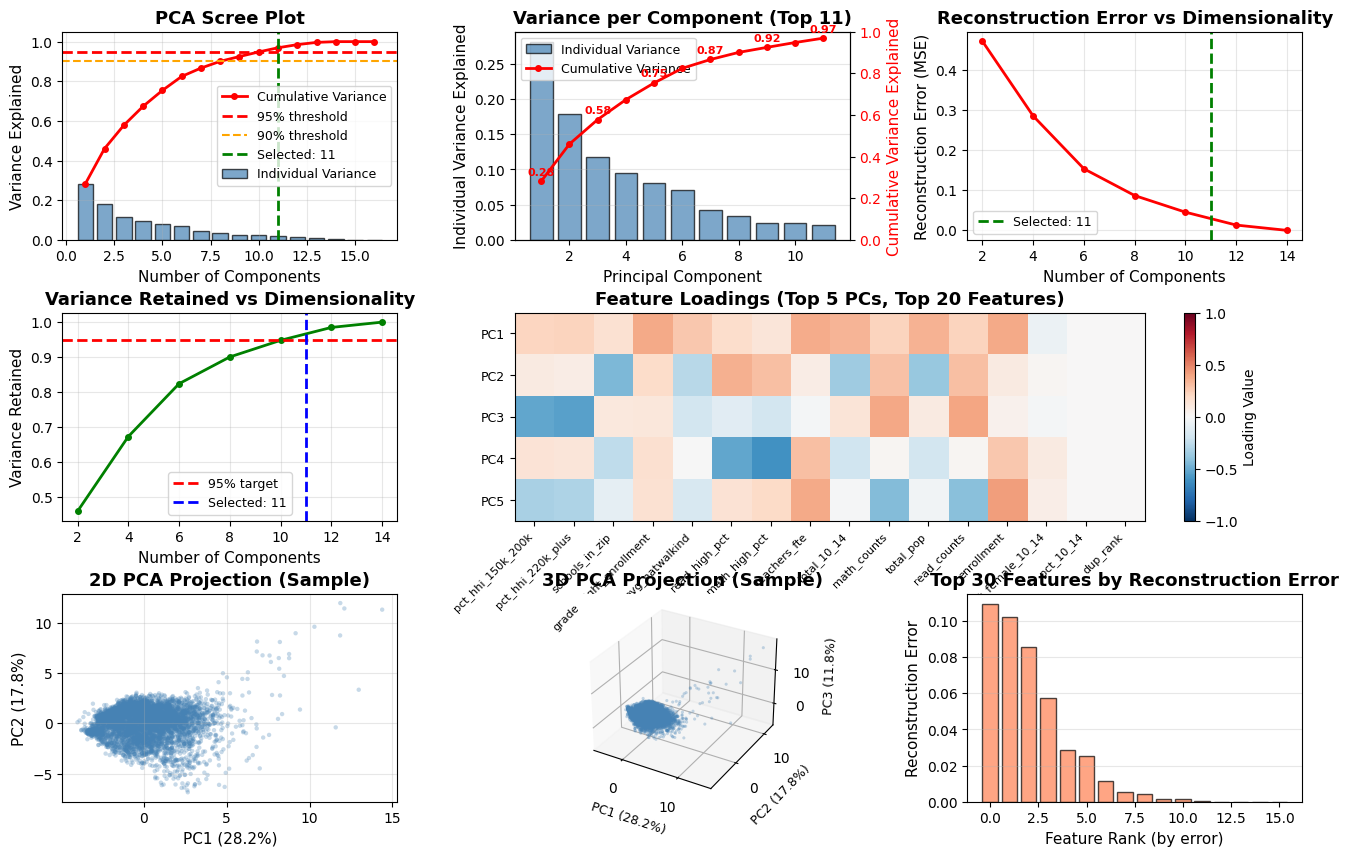


✅ PCA visualization saved to: D:\docs\MADS\696-Milestone 2\unsupervised\pca_comprehensive_analysis.png


In [29]:
# --- PCA Visualizations ---

# 6. Visualizations
print(f"\n[PCA] Step 6: Generating visualizations...")

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# 6.1 Scree plot
ax1 = fig.add_subplot(gs[0, 0])
n_plot = min(50, len(cumsum_variance))
# Bars for individual variance
ax1.bar(range(1, n_plot+1), pca_full.explained_variance_ratio_[:n_plot], 
        color='steelblue', alpha=0.7, edgecolor='black', label='Individual Variance')
# Line for cumulative variance
ax1.plot(range(1, n_plot+1), cumsum_variance[:n_plot], 'ro-', linewidth=2, markersize=4, label='Cumulative Variance')
ax1.axhline(y=0.95, color='r', linestyle='--', label='95% threshold', linewidth=2)
ax1.axhline(y=0.90, color='orange', linestyle='--', label='90% threshold', linewidth=1.5)
ax1.axvline(x=final_n_components, color='g', linestyle='--', label=f'Selected: {final_n_components}', linewidth=2)
ax1.set_xlabel('Number of Components', fontsize=11)
ax1.set_ylabel('Variance Explained', fontsize=11)
ax1.set_title('PCA Scree Plot', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# 6.2 Individual variance per component
ax2 = fig.add_subplot(gs[0, 1])
n_bars = min(20, final_n_components)
bars = ax2.bar(range(1, n_bars+1), pca_optimal.explained_variance_ratio_[:n_bars], 
        color='steelblue', alpha=0.7, edgecolor='black', label='Individual Variance')
ax2.set_xlabel('Principal Component', fontsize=11)
ax2.set_ylabel('Individual Variance Explained', fontsize=11)
ax2.set_title(f'Variance per Component (Top {n_bars})', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Secondary axis for cumulative variance
ax2_twin = ax2.twinx()
cum_var_top = np.cumsum(pca_optimal.explained_variance_ratio_[:n_bars])
line, = ax2_twin.plot(range(1, n_bars+1), cum_var_top, 'ro-', linewidth=2, markersize=4, label='Cumulative Variance')
ax2_twin.set_ylabel('Cumulative Variance Explained', fontsize=11, color='red')
ax2_twin.tick_params(axis='y', labelcolor='red')
ax2_twin.set_ylim(0, 1)

# Add value labels on the cumulative line
for i, (x, y) in enumerate(zip(range(1, n_bars+1), cum_var_top)):
    if i % 2 == 0 or i == n_bars - 1:  # Label every other point and the last one
        ax2_twin.text(x, y + 0.02, f'{y:.2f}', ha='center', va='bottom', fontsize=8, color='red', fontweight='bold')

# Combined legend
lines = [bars, line]
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, fontsize=9, loc='upper left')

# 6.3 Reconstruction error vs n_components
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(n_components_range, reconstruction_errors, 'ro-', linewidth=2, markersize=4)
ax3.axvline(x=final_n_components, color='g', linestyle='--', 
           label=f'Selected: {final_n_components}', linewidth=2)
ax3.set_xlabel('Number of Components', fontsize=11)
ax3.set_ylabel('Reconstruction Error (MSE)', fontsize=11)
ax3.set_title('Reconstruction Error vs Dimensionality', fontsize=13, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)

# 6.4 Variance retained vs n_components
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(n_components_range, variance_retained_list, 'go-', linewidth=2, markersize=4)
ax4.axhline(y=0.95, color='r', linestyle='--', label='95% target', linewidth=2)
ax4.axvline(x=final_n_components, color='b', linestyle='--', 
           label=f'Selected: {final_n_components}', linewidth=2)
ax4.set_xlabel('Number of Components', fontsize=11)
ax4.set_ylabel('Variance Retained', fontsize=11)
ax4.set_title('Variance Retained vs Dimensionality', fontsize=13, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3)

# 6.5 Feature loading heatmap (top 5 PCs, top 20 features)
ax5 = fig.add_subplot(gs[1, 1:])
n_pcs_heatmap = min(5, final_n_components)
top_features_idx = feature_importance_pca.head(20).index
loadings_subset = loadings[:n_pcs_heatmap, top_features_idx]
feature_names_subset = [feature_names[i] for i in top_features_idx]

im = ax5.imshow(loadings_subset, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
ax5.set_yticks(range(n_pcs_heatmap))
ax5.set_yticklabels([f'PC{i+1}' for i in range(n_pcs_heatmap)], fontsize=9)
ax5.set_xticks(range(len(feature_names_subset)))
ax5.set_xticklabels(feature_names_subset, rotation=45, ha='right', fontsize=8)
ax5.set_title('Feature Loadings (Top 5 PCs, Top 20 Features)', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=ax5, label='Loading Value')

# 6.6 2D PCA visualization
ax6 = fig.add_subplot(gs[2, 0])
sample_indices = np.random.choice(X_reduced.shape[0], size=min(5000, X_reduced.shape[0]), replace=False)
ax6.scatter(X_reduced[sample_indices, 0], X_reduced[sample_indices, 1], 
           alpha=0.3, s=10, c='steelblue', edgecolors='none')
ax6.set_xlabel(f'PC1 ({pca_optimal.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax6.set_ylabel(f'PC2 ({pca_optimal.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax6.set_title('2D PCA Projection (Sample)', fontsize=13, fontweight='bold')
ax6.grid(alpha=0.3)

# 6.7 3D PCA visualization
if final_n_components >= 3:
    ax7 = fig.add_subplot(gs[2, 1], projection='3d')
    ax7.scatter(X_reduced[sample_indices, 0], X_reduced[sample_indices, 1], X_reduced[sample_indices, 2],
               alpha=0.3, s=5, c='steelblue', edgecolors='none')
    ax7.set_xlabel(f'PC1 ({pca_optimal.explained_variance_ratio_[0]*100:.1f}%)', fontsize=9)
    ax7.set_ylabel(f'PC2 ({pca_optimal.explained_variance_ratio_[1]*100:.1f}%)', fontsize=9)
    ax7.set_zlabel(f'PC3 ({pca_optimal.explained_variance_ratio_[2]*100:.1f}%)', fontsize=9)
    ax7.set_title('3D PCA Projection (Sample)', fontsize=13, fontweight='bold')

# 6.8 Per-feature reconstruction error
ax8 = fig.add_subplot(gs[2, 2])
sorted_errors = np.sort(feature_reconstruction_errors)[::-1]
ax8.bar(range(len(sorted_errors[:30])), sorted_errors[:30], color='coral', alpha=0.7, edgecolor='black')
ax8.set_xlabel('Feature Rank (by error)', fontsize=11)
ax8.set_ylabel('Reconstruction Error', fontsize=11)
ax8.set_title('Top 30 Features by Reconstruction Error', fontsize=13, fontweight='bold')
ax8.grid(axis='y', alpha=0.3)

plt.savefig(MODEL_DIR / 'pca_comprehensive_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ PCA visualization saved to: {MODEL_DIR / 'pca_comprehensive_analysis.png'}")

In [30]:
# --- PCA Model Saving ---

# 7. Save PCA model and metadata
print(f"\n[PCA] Step 7: Saving PCA model and metadata...")

pca_extra = {
    'metrics': pca_metrics,
    'optimization': {
        'method': 'variance_threshold',
        'target_variance': 0.95,
        'elbow_method_suggestion': int(elbow_n),
        'final_choice': int(final_n_components),
        'thresholds': {
            '80pct': int(n_80),
            '90pct': int(n_90),
            '95pct': int(n_95),
            '99pct': int(n_99)
        }
    },
    'data_shape': {
        'original': list(X_full.shape),
        'reduced': list(X_reduced.shape)
    },
    'top_features': feature_importance_pca.head(20).to_dict('records')
}

save_model(pca_optimal, 'pca_optimal', pca_extra)

# Save feature importance
feature_importance_pca.to_csv(MODEL_DIR / 'pca_feature_importance.csv', index=False)

print(f"\n{'='*80}")
print(" " * 25 + "PCA ANALYSIS COMPLETE")
print(f"{'='*80}")
print(f"\n✅ PCA model saved: {final_n_components} components")
print(f"✅ Dimensionality reduced by {dimensionality_reduction_pct:.1f}%")
print(f"✅ Retained {final_variance_retained*100:.2f}% of variance")
print(f"✅ Reconstruction RMSE: {final_rmse:.6f}")
print(f"✅ Feature importance saved to: {MODEL_DIR / 'pca_feature_importance.csv'}")


[PCA] Step 7: Saving PCA model and metadata...
Saved model -> pca_optimal_20251012T221234Z.joblib; metadata -> pca_optimal_20251012T221234Z.json

                         PCA ANALYSIS COMPLETE

✅ PCA model saved: 11 components
✅ Dimensionality reduced by 31.2%
✅ Retained 96.91% of variance
✅ Reconstruction RMSE: 0.164420
✅ Feature importance saved to: D:\docs\MADS\696-Milestone 2\unsupervised\pca_feature_importance.csv


## 5. Visualization (2D PCA Projections)
We project the full standardized feature matrix to 2 principal components (outside of optimization) for consistent side-by-side cluster plots.

In [31]:
import plotly.express as px

# Refit best models on (possibly PCA-transformed) feature space chosen by best trial
best_kmeans_params = study_kmeans.best_trial.params
best_gmm_params = study_gmm.best_trial.params

# Build best models again without PCA reduction (for consistent plotting base); PCA only for 2D viz
# Check for pretrained models first
if kmeans_best is None or FORCE_RETRAIN:
    print("Building new KMeans model...")
    kmeans_best = KMeans(
        n_clusters=best_kmeans_params['kmeans_n_clusters'],
        init=best_kmeans_params['kmeans_init'],
        algorithm=best_kmeans_params['kmeans_algorithm'],
        n_init='auto',
        random_state=42
    ).fit(X_full)
    # Save the model
    kmeans_extra = {
        'n_trials': len(study_kmeans.trials),
        'best_silhouette': float(study_kmeans.best_value),
        'hyperparameters': best_kmeans_params
    }
    save_model(kmeans_best, 'kmeans_best', kmeans_extra)

if gmm_best is None or FORCE_RETRAIN:
    print("Building new GMM model...")
    gmm_best = GaussianMixture(
        n_components=best_gmm_params['gmm_n_components'],
        covariance_type=best_gmm_params['gmm_covariance_type'],
        reg_covar=best_gmm_params['gmm_reg_covar'],
        random_state=42
    ).fit(X_full)
    # Save the model
    gmm_extra = {
        'n_trials': len(study_gmm.trials),
        'best_silhouette': float(study_gmm.best_value),
        'hyperparameters': best_gmm_params
    }
    save_model(gmm_best, 'gmm_best', gmm_extra)

labels_kmeans = kmeans_best.predict(X_full)
labels_gmm = gmm_best.predict(X_full)

# PCA for viz only
pca_viz = PCA(n_components=2, random_state=42)
X_2d = pca_viz.fit_transform(X_full)
plot_df = pd.DataFrame({
    'PC1': X_2d[:,0],
    'PC2': X_2d[:,1],
    'KMeans_Cluster': labels_kmeans.astype(str),
    'GMM_Cluster': labels_gmm.astype(str)
})

fig1 = px.scatter(plot_df, x='PC1', y='PC2', color='KMeans_Cluster', title='KMeans Clusters (PCA 2D)')
fig1.show()
fig2 = px.scatter(plot_df, x='PC1', y='PC2', color='GMM_Cluster', title='GMM Clusters (PCA 2D)')
fig2.show()

print("Visualization complete.")

ValueError: X has 16 features, but KMeans is expecting 20 features as input.

## 6. Cluster Profiling & Comparison
Generate aggregate statistics per cluster for both algorithms and compare metrics side-by-side.

In [ ]:
# --- Comprehensive Model Comparison & Analysis ---

# Generate predictions from best models
labels_kmeans = kmeans_best.predict(X_full)
labels_gmm = gmm_best.predict(X_full)

# Recompute metrics for final comparison
kmeans_final_metrics = compute_cluster_metrics(X_full, labels_kmeans)
gmm_final_metrics = compute_cluster_metrics(X_full, labels_gmm)

## 7. Notes & Next Steps
Potential enhancements:
- Add DBSCAN / HDBSCAN for density-based perspective.
- Use feature selection or domain-driven grouping before clustering.
- Evaluate stability across bootstrap samples.
- Store cluster assignments back to database for downstream analytics.

## 8. Persist Best Models
Save best KMeans and GMM models, hyperparameters, and metrics into `src/unsupervised/` for reuse.

Metrics to compute later:
- Silhouette Score (higher better)
- Calinski-Harabasz Index (higher better)
- Davies-Bouldin Index (lower better)

We'll define reusable helper functions so both model families share logic.

## 11. Advanced Metric Performance Analysis
Deep dive into clustering quality metrics with statistical tests and visualizations.

In [ ]:
# --- Metric Stability Analysis: Bootstrap Resampling ---
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style('whitegrid')

N_BOOTSTRAP = 30  # Number of bootstrap samples
SAMPLE_SIZE = min(5000, len(X_full))  # Sample size for each bootstrap iteration

print(f"=== BOOTSTRAP STABILITY ANALYSIS ===")
print(f"Running {N_BOOTSTRAP} bootstrap iterations with sample size {SAMPLE_SIZE}...")

kmeans_sil_scores = []
gmm_sil_scores = []
kmeans_ch_scores = []
gmm_ch_scores = []
kmeans_db_scores = []
gmm_db_scores = []

np.random.seed(42)
for i in range(N_BOOTSTRAP):
    # Sample with replacement
    indices = np.random.choice(len(X_full), size=SAMPLE_SIZE, replace=True)
    X_boot = X_full[indices]
    
    # KMeans predictions
    labels_k = kmeans_best.predict(X_boot)
    metrics_k = compute_cluster_metrics(X_boot, labels_k)
    kmeans_sil_scores.append(metrics_k['silhouette'])
    kmeans_ch_scores.append(metrics_k['calinski_harabasz'])
    kmeans_db_scores.append(metrics_k['davies_bouldin'])
    
    # GMM predictions
    labels_g = gmm_best.predict(X_boot)
    metrics_g = compute_cluster_metrics(X_boot, labels_g)
    gmm_sil_scores.append(metrics_g['silhouette'])
    gmm_ch_scores.append(metrics_g['calinski_harabasz'])
    gmm_db_scores.append(metrics_g['davies_bouldin'])
    
    if (i + 1) % 10 == 0:
        print(f"  Completed {i + 1}/{N_BOOTSTRAP} iterations...")

# Calculate statistics
bootstrap_stats = pd.DataFrame({
    'Metric': ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'] * 2,
    'Model': ['KMeans']*3 + ['GMM']*3,
    'Mean': [
        np.mean(kmeans_sil_scores), np.mean(kmeans_ch_scores), np.mean(kmeans_db_scores),
        np.mean(gmm_sil_scores), np.mean(gmm_ch_scores), np.mean(gmm_db_scores)
    ],
    'Std': [
        np.std(kmeans_sil_scores), np.std(kmeans_ch_scores), np.std(kmeans_db_scores),
        np.std(gmm_sil_scores), np.std(gmm_ch_scores), np.std(gmm_db_scores)
    ],
    'Min': [
        np.min(kmeans_sil_scores), np.min(kmeans_ch_scores), np.min(kmeans_db_scores),
        np.min(gmm_sil_scores), np.min(gmm_ch_scores), np.min(gmm_db_scores)
    ],
    'Max': [
        np.max(kmeans_sil_scores), np.max(kmeans_ch_scores), np.max(kmeans_db_scores),
        np.max(gmm_sil_scores), np.max(gmm_ch_scores), np.max(gmm_db_scores)
    ],
    'CV': [
        np.std(kmeans_sil_scores)/np.mean(kmeans_sil_scores),
        np.std(kmeans_ch_scores)/np.mean(kmeans_ch_scores),
        np.std(kmeans_db_scores)/np.mean(kmeans_db_scores),
        np.std(gmm_sil_scores)/np.mean(gmm_sil_scores),
        np.std(gmm_ch_scores)/np.mean(gmm_ch_scores),
        np.std(gmm_db_scores)/np.mean(gmm_db_scores)
    ]
})

print("\n=== BOOTSTRAP METRIC STABILITY ===")
display(bootstrap_stats.round(4))

# Statistical significance tests
print("\n=== STATISTICAL SIGNIFICANCE TESTS (Mann-Whitney U) ===")
sil_stat, sil_pval = stats.mannwhitneyu(kmeans_sil_scores, gmm_sil_scores, alternative='two-sided')
ch_stat, ch_pval = stats.mannwhitneyu(kmeans_ch_scores, gmm_ch_scores, alternative='two-sided')
db_stat, db_pval = stats.mannwhitneyu(kmeans_db_scores, gmm_db_scores, alternative='two-sided')

print(f"Silhouette Score: U={sil_stat:.2f}, p-value={sil_pval:.4f} {'***' if sil_pval < 0.001 else '**' if sil_pval < 0.01 else '*' if sil_pval < 0.05 else 'ns'}")
print(f"Calinski-Harabasz: U={ch_stat:.2f}, p-value={ch_pval:.4f} {'***' if ch_pval < 0.001 else '**' if ch_pval < 0.01 else '*' if ch_pval < 0.05 else 'ns'}")
print(f"Davies-Bouldin: U={db_stat:.2f}, p-value={db_pval:.4f} {'***' if db_pval < 0.001 else '**' if db_pval < 0.01 else '*' if db_pval < 0.05 else 'ns'}")

In [ ]:
# --- Bootstrap Visualizations ---

# Visualize bootstrap distributions
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].hist(kmeans_sil_scores, alpha=0.5, bins=15, label='KMeans', color='blue')
axes[0].hist(gmm_sil_scores, alpha=0.5, bins=15, label='GMM', color='orange')
axes[0].set_xlabel('Silhouette Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Silhouette Score Distribution (Bootstrap)', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].axvline(np.mean(kmeans_sil_scores), color='blue', linestyle='--', linewidth=2)
axes[0].axvline(np.mean(gmm_sil_scores), color='orange', linestyle='--', linewidth=2)

axes[1].hist(kmeans_ch_scores, alpha=0.5, bins=15, label='KMeans', color='blue')
axes[1].hist(gmm_ch_scores, alpha=0.5, bins=15, label='GMM', color='orange')
axes[1].set_xlabel('Calinski-Harabasz Index', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Calinski-Harabasz Distribution (Bootstrap)', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].axvline(np.mean(kmeans_ch_scores), color='blue', linestyle='--', linewidth=2)
axes[1].axvline(np.mean(gmm_ch_scores), color='orange', linestyle='--', linewidth=2)

axes[2].hist(kmeans_db_scores, alpha=0.5, bins=15, label='KMeans', color='blue')
axes[2].hist(gmm_db_scores, alpha=0.5, bins=15, label='GMM', color='orange')
axes[2].set_xlabel('Davies-Bouldin Index', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Davies-Bouldin Distribution (Bootstrap)', fontsize=14)
axes[2].legend(fontsize=10)
axes[2].axvline(np.mean(kmeans_db_scores), color='blue', linestyle='--', linewidth=2)
axes[2].axvline(np.mean(gmm_db_scores), color='orange', linestyle='--', linewidth=2)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'bootstrap_metric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Bootstrap distribution plot saved to: {MODEL_DIR / 'bootstrap_metric_distributions.png'}")

## 12. Cluster Quality Deep Dive
Analyze within-cluster cohesion, between-cluster separation, and silhouette analysis per cluster.

In [ ]:
# --- Per-Cluster Silhouette Analysis ---
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import cdist

print("=== PER-CLUSTER SILHOUETTE ANALYSIS ===\n")

# Calculate silhouette scores for each sample
silhouette_kmeans = silhouette_samples(X_full, labels_kmeans)
silhouette_gmm = silhouette_samples(X_full, labels_gmm)

# KMeans per-cluster analysis
kmeans_cluster_silhouettes = []
for i in range(best_kmeans_params['kmeans_n_clusters']):
    cluster_mask = labels_kmeans == i
    cluster_sil = silhouette_kmeans[cluster_mask]
    kmeans_cluster_silhouettes.append({
        'Cluster': i,
        'Size': cluster_mask.sum(),
        'Mean_Silhouette': cluster_sil.mean(),
        'Std_Silhouette': cluster_sil.std(),
        'Min_Silhouette': cluster_sil.min(),
        'Max_Silhouette': cluster_sil.max(),
        'Pct_Negative': (cluster_sil < 0).sum() / len(cluster_sil) * 100
    })

kmeans_sil_df = pd.DataFrame(kmeans_cluster_silhouettes)
print("KMeans - Per-Cluster Silhouette Scores:")
display(kmeans_sil_df.round(4))

# GMM per-cluster analysis
gmm_cluster_silhouettes = []
for i in range(best_gmm_params['gmm_n_components']):
    cluster_mask = labels_gmm == i
    cluster_sil = silhouette_gmm[cluster_mask]
    gmm_cluster_silhouettes.append({
        'Cluster': i,
        'Size': cluster_mask.sum(),
        'Mean_Silhouette': cluster_sil.mean(),
        'Std_Silhouette': cluster_sil.std(),
        'Min_Silhouette': cluster_sil.min(),
        'Max_Silhouette': cluster_sil.max(),
        'Pct_Negative': (cluster_sil < 0).sum() / len(cluster_sil) * 100
    })

gmm_sil_df = pd.DataFrame(gmm_cluster_silhouettes)
print("\nGMM - Per-Cluster Silhouette Scores:")
display(gmm_sil_df.round(4))

# Visualize silhouette plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# KMeans silhouette plot
y_lower = 10
for i in range(best_kmeans_params['kmeans_n_clusters']):
    cluster_sil_values = silhouette_kmeans[labels_kmeans == i]
    cluster_sil_values.sort()
    
    size_cluster_i = cluster_sil_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / best_kmeans_params['kmeans_n_clusters'])
    axes[0].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    axes[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

axes[0].set_xlabel('Silhouette Coefficient', fontsize=12)
axes[0].set_ylabel('Cluster Label', fontsize=12)
axes[0].set_title(f'KMeans Silhouette Plot (n={best_kmeans_params["kmeans_n_clusters"]} clusters)', fontsize=14)
axes[0].axvline(x=silhouette_kmeans.mean(), color="red", linestyle="--", label=f'Mean: {silhouette_kmeans.mean():.3f}')
axes[0].legend(fontsize=10)

# GMM silhouette plot
y_lower = 10
for i in range(best_gmm_params['gmm_n_components']):
    cluster_sil_values = silhouette_gmm[labels_gmm == i]
    cluster_sil_values.sort()
    
    size_cluster_i = cluster_sil_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / best_gmm_params['gmm_n_components'])
    axes[1].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    axes[1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

axes[1].set_xlabel('Silhouette Coefficient', fontsize=12)
axes[1].set_ylabel('Cluster Label', fontsize=12)
axes[1].set_title(f'GMM Silhouette Plot (n={best_gmm_params["gmm_n_components"]} components)', fontsize=14)
axes[1].axvline(x=silhouette_gmm.mean(), color="red", linestyle="--", label=f'Mean: {silhouette_gmm.mean():.3f}')
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'silhouette_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Silhouette plots saved to: {MODEL_DIR / 'silhouette_plots.png'}")

# Identify poorly clustered samples
kmeans_poorly_clustered = (silhouette_kmeans < 0).sum()
gmm_poorly_clustered = (silhouette_gmm < 0).sum()

print(f"\n=== POORLY CLUSTERED SAMPLES (Negative Silhouette) ===")
print(f"KMeans: {kmeans_poorly_clustered} samples ({kmeans_poorly_clustered/len(X_full)*100:.2f}%)")
print(f"GMM: {gmm_poorly_clustered} samples ({gmm_poorly_clustered/len(X_full)*100:.2f}%)")

In [ ]:
# --- Intra-cluster & Inter-cluster Distance Analysis ---

print("=== INTRA-CLUSTER AND INTER-CLUSTER DISTANCE ANALYSIS ===\n")

# KMeans analysis
kmeans_centers = kmeans_best.cluster_centers_
kmeans_intra_distances = []
kmeans_cluster_compactness = []

for i in range(best_kmeans_params['kmeans_n_clusters']):
    cluster_points = X_full[labels_kmeans == i]
    center = kmeans_centers[i]
    # Calculate distances to cluster center
    distances = np.linalg.norm(cluster_points - center, axis=1)
    kmeans_intra_distances.extend(distances)
    kmeans_cluster_compactness.append({
        'Cluster': i,
        'Mean_Distance_to_Center': distances.mean(),
        'Std_Distance': distances.std(),
        'Max_Distance': distances.max(),
        'Radius_95pct': np.percentile(distances, 95)
    })

# Inter-cluster distances (center-to-center)
kmeans_inter_distances = cdist(kmeans_centers, kmeans_centers, metric='euclidean')
np.fill_diagonal(kmeans_inter_distances, np.nan)  # Ignore self-distances

kmeans_compactness_df = pd.DataFrame(kmeans_cluster_compactness)
print("KMeans - Cluster Compactness (Distance to Center):")
display(kmeans_compactness_df.round(4))

print(f"\nKMeans - Inter-cluster distances (center-to-center):")
print(f"  Mean: {np.nanmean(kmeans_inter_distances):.4f}")
print(f"  Min: {np.nanmin(kmeans_inter_distances):.4f}")
print(f"  Max: {np.nanmax(kmeans_inter_distances):.4f}")
print(f"  Separation Ratio (inter/intra): {np.nanmean(kmeans_inter_distances) / np.mean(kmeans_intra_distances):.4f}")

# GMM analysis - use predicted cluster centers (mean of each component)
gmm_cluster_compactness = []
gmm_intra_distances = []

for i in range(best_gmm_params['gmm_n_components']):
    cluster_points = X_full[labels_gmm == i]
    center = cluster_points.mean(axis=0)  # Empirical center
    distances = np.linalg.norm(cluster_points - center, axis=1)
    gmm_intra_distances.extend(distances)
    gmm_cluster_compactness.append({
        'Cluster': i,
        'Mean_Distance_to_Center': distances.mean(),
        'Std_Distance': distances.std(),
        'Max_Distance': distances.max(),
        'Radius_95pct': np.percentile(distances, 95)
    })

# GMM inter-cluster distances
gmm_centers = np.array([X_full[labels_gmm == i].mean(axis=0) for i in range(best_gmm_params['gmm_n_components'])])
gmm_inter_distances = cdist(gmm_centers, gmm_centers, metric='euclidean')
np.fill_diagonal(gmm_inter_distances, np.nan)

gmm_compactness_df = pd.DataFrame(gmm_cluster_compactness)
print("\nGMM - Cluster Compactness (Distance to Empirical Center):")
display(gmm_compactness_df.round(4))

print(f"\nGMM - Inter-cluster distances (center-to-center):")
print(f"  Mean: {np.nanmean(gmm_inter_distances):.4f}")
print(f"  Min: {np.nanmin(gmm_inter_distances):.4f}")
print(f"  Max: {np.nanmax(gmm_inter_distances):.4f}")
print(f"  Separation Ratio (inter/intra): {np.nanmean(gmm_inter_distances) / np.mean(gmm_intra_distances):.4f}")

# Visualize distance distributions
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(kmeans_intra_distances, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_xlabel('Distance to Cluster Center', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('KMeans - Intra-cluster Distance Distribution', fontsize=14)
axes[0].axvline(np.mean(kmeans_intra_distances), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(kmeans_intra_distances):.3f}')
axes[0].legend(fontsize=10)

axes[1].hist(gmm_intra_distances, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1].set_xlabel('Distance to Cluster Center', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('GMM - Intra-cluster Distance Distribution', fontsize=14)
axes[1].axvline(np.mean(gmm_intra_distances), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(gmm_intra_distances):.3f}')
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'distance_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Distance distribution plots saved to: {MODEL_DIR / 'distance_distributions.png'}")

## 13. Feature Importance & Cluster Characterization
Identify which features drive cluster separation and characterize each cluster.

In [ ]:
# --- Feature Importance via ANOVA F-statistic ---
from sklearn.feature_selection import f_classif

print("=== FEATURE IMPORTANCE FOR CLUSTER SEPARATION ===\n")

# Calculate F-statistics for each feature across clusters
f_stats_kmeans, p_values_kmeans = f_classif(X_full, labels_kmeans)
f_stats_gmm, p_values_gmm = f_classif(X_full, labels_gmm)

# Create feature importance DataFrame
feature_names = df_numeric.columns.tolist()
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'KMeans_F_Stat': f_stats_kmeans,
    'KMeans_P_Value': p_values_kmeans,
    'GMM_F_Stat': f_stats_gmm,
    'GMM_P_Value': p_values_gmm
})

# Rank features
feature_importance['KMeans_Rank'] = feature_importance['KMeans_F_Stat'].rank(ascending=False)
feature_importance['GMM_Rank'] = feature_importance['GMM_F_Stat'].rank(ascending=False)
feature_importance['Avg_Rank'] = (feature_importance['KMeans_Rank'] + feature_importance['GMM_Rank']) / 2

# Sort by average rank
feature_importance = feature_importance.sort_values('Avg_Rank')

print("Top 20 Most Important Features for Cluster Separation:")
display(feature_importance.head(20))

print("\nBottom 10 Least Important Features:")
display(feature_importance.tail(10))

# Visualize top features
top_n = 15
top_features = feature_importance.head(top_n)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# KMeans feature importance
axes[0].barh(range(top_n), top_features['KMeans_F_Stat'].values)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_features['Feature'].values, fontsize=9)
axes[0].invert_yaxis()
axes[0].set_xlabel('F-Statistic', fontsize=12)
axes[0].set_title('Top 15 Features - KMeans Cluster Separation', fontsize=14)
axes[0].grid(axis='x', alpha=0.3)

# GMM feature importance
axes[1].barh(range(top_n), top_features['GMM_F_Stat'].values, color='orange')
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(top_features['Feature'].values, fontsize=9)
axes[1].invert_yaxis()
axes[1].set_xlabel('F-Statistic', fontsize=12)
axes[1].set_title('Top 15 Features - GMM Cluster Separation', fontsize=14)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Feature importance plot saved to: {MODEL_DIR / 'feature_importance.png'}")

# Save feature importance to CSV
feature_importance.to_csv(MODEL_DIR / 'feature_importance.csv', index=False)
print(f"💾 Feature importance saved to: {MODEL_DIR / 'feature_importance.csv'}")

In [ ]:
# --- Cluster Characterization: Statistical Profiles ---

print("=== CLUSTER CHARACTERIZATION ===\n")

# Get top 10 most important features for detailed profiling
top_10_features = feature_importance.head(10)['Feature'].tolist()

# Add cluster labels to original numeric dataframe
profile_df_kmeans = df_numeric[top_10_features].copy()
profile_df_kmeans['cluster'] = labels_kmeans

profile_df_gmm = df_numeric[top_10_features].copy()
profile_df_gmm['cluster'] = labels_gmm

# KMeans cluster profiles
print("KMeans - Cluster Profiles (Top 10 Features):")
kmeans_profiles = profile_df_kmeans.groupby('cluster').agg(['mean', 'std', 'median', 'min', 'max'])
display(kmeans_profiles.round(3))

# GMM cluster profiles
print("\nGMM - Cluster Profiles (Top 10 Features):")
gmm_profiles = profile_df_gmm.groupby('cluster').agg(['mean', 'std', 'median', 'min', 'max'])
display(gmm_profiles.round(3))

# Create heatmap of cluster centers (standardized features)
print("\n=== CLUSTER CENTER HEATMAPS ===")

# KMeans centers for top features
top_feature_indices = [df_numeric.columns.get_loc(f) for f in top_10_features]
kmeans_centers_top = kmeans_centers[:, top_feature_indices]

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# KMeans heatmap
im1 = axes[0].imshow(kmeans_centers_top, cmap='RdBu_r', aspect='auto', interpolation='nearest')
axes[0].set_xticks(range(len(top_10_features)))
axes[0].set_xticklabels(top_10_features, rotation=45, ha='right', fontsize=9)
axes[0].set_yticks(range(best_kmeans_params['kmeans_n_clusters']))
axes[0].set_yticklabels([f"Cluster {i}" for i in range(best_kmeans_params['kmeans_n_clusters'])], fontsize=10)
axes[0].set_title('KMeans Cluster Centers (Standardized)', fontsize=14)
plt.colorbar(im1, ax=axes[0])

# GMM centers (empirical) for top features
gmm_centers_top = gmm_centers[:, top_feature_indices]
im2 = axes[1].imshow(gmm_centers_top, cmap='RdBu_r', aspect='auto', interpolation='nearest')
axes[1].set_xticks(range(len(top_10_features)))
axes[1].set_xticklabels(top_10_features, rotation=45, ha='right', fontsize=9)
axes[1].set_yticks(range(best_gmm_params['gmm_n_components']))
axes[1].set_yticklabels([f"Cluster {i}" for i in range(best_gmm_params['gmm_n_components'])], fontsize=10)
axes[1].set_title('GMM Cluster Centers (Standardized)', fontsize=14)
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.savefig(MODEL_DIR / 'cluster_center_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Cluster center heatmaps saved to: {MODEL_DIR / 'cluster_center_heatmaps.png'}")

# Identify most distinctive clusters (highest variance in features)
kmeans_cluster_distinctiveness = []
for i in range(best_kmeans_params['kmeans_n_clusters']):
    center_distances = np.linalg.norm(kmeans_centers - kmeans_centers[i], axis=1)
    center_distances[i] = np.inf  # Exclude self
    kmeans_cluster_distinctiveness.append({
        'Cluster': i,
        'Min_Distance_to_Other': center_distances.min(),
        'Mean_Distance_to_Others': center_distances[center_distances != np.inf].mean()
    })

kmeans_distinct_df = pd.DataFrame(kmeans_cluster_distinctiveness)
print("\nKMeans - Cluster Distinctiveness (Distance from other clusters):")
display(kmeans_distinct_df.round(4))

gmm_cluster_distinctiveness = []
for i in range(best_gmm_params['gmm_n_components']):
    center_distances = np.linalg.norm(gmm_centers - gmm_centers[i], axis=1)
    center_distances[i] = np.inf  # Exclude self
    gmm_cluster_distinctiveness.append({
        'Cluster': i,
        'Min_Distance_to_Other': center_distances.min(),
        'Mean_Distance_to_Others': center_distances[center_distances != np.inf].mean()
    })

gmm_distinct_df = pd.DataFrame(gmm_cluster_distinctiveness)
print("\nGMM - Cluster Distinctiveness (Distance from other clusters):")
display(gmm_distinct_df.round(4))

## 14. Cluster Agreement & Overlap Analysis
Compare cluster assignments between KMeans and GMM to understand model agreement.

In [ ]:
# --- Cluster Agreement Analysis ---
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.metrics.cluster import contingency_matrix

print("=== CLUSTER AGREEMENT BETWEEN KMEANS AND GMM ===\n")

# Calculate agreement metrics
ari = adjusted_rand_score(labels_kmeans, labels_gmm)
nmi = normalized_mutual_info_score(labels_kmeans, labels_gmm)
fmi = fowlkes_mallows_score(labels_kmeans, labels_gmm)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"  Interpretation: {ari:.4f} {'(Perfect agreement)' if ari > 0.9 else '(High agreement)' if ari > 0.7 else '(Moderate agreement)' if ari > 0.4 else '(Low agreement)'}")
print(f"\nNormalized Mutual Information (NMI): {nmi:.4f}")
print(f"  Interpretation: {nmi:.4f} {'(Perfect agreement)' if nmi > 0.9 else '(High agreement)' if nmi > 0.7 else '(Moderate agreement)' if nmi > 0.4 else '(Low agreement)'}")
print(f"\nFowlkes-Mallows Index (FMI): {fmi:.4f}")
print(f"  Interpretation: {fmi:.4f} {'(Perfect agreement)' if fmi > 0.9 else '(High agreement)' if fmi > 0.7 else '(Moderate agreement)' if fmi > 0.4 else '(Low agreement)'}")

# Create contingency matrix
contingency = contingency_matrix(labels_kmeans, labels_gmm)
contingency_df = pd.DataFrame(
    contingency,
    index=[f'KMeans_{i}' for i in range(best_kmeans_params['kmeans_n_clusters'])],
    columns=[f'GMM_{i}' for i in range(best_gmm_params['gmm_n_components'])]
)

print("\n=== CONTINGENCY TABLE (Sample Overlap) ===")
print("Rows: KMeans clusters, Columns: GMM clusters")
display(contingency_df)

# Visualize contingency matrix as heatmap
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(contingency, cmap='YlOrRd', aspect='auto')

# Add text annotations
for i in range(contingency.shape[0]):
    for j in range(contingency.shape[1]):
        text = ax.text(j, i, contingency[i, j],
                      ha="center", va="center", color="black" if contingency[i, j] < contingency.max()/2 else "white")

ax.set_xticks(range(best_gmm_params['gmm_n_components']))
ax.set_yticks(range(best_kmeans_params['kmeans_n_clusters']))
ax.set_xticklabels([f'GMM {i}' for i in range(best_gmm_params['gmm_n_components'])], fontsize=10)
ax.set_yticklabels([f'KMeans {i}' for i in range(best_kmeans_params['kmeans_n_clusters'])], fontsize=10)
ax.set_xlabel('GMM Clusters', fontsize=12)
ax.set_ylabel('KMeans Clusters', fontsize=12)
ax.set_title('Cluster Overlap: KMeans vs GMM\n(Number of shared samples)', fontsize=14)
plt.colorbar(im, ax=ax, label='Sample Count')

plt.tight_layout()
plt.savefig(MODEL_DIR / 'cluster_agreement_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Cluster agreement heatmap saved to: {MODEL_DIR / 'cluster_agreement_heatmap.png'}")

# Identify samples with different cluster assignments
disagreement_mask = labels_kmeans != labels_gmm
n_disagreements = disagreement_mask.sum()
pct_disagreement = (n_disagreements / len(labels_kmeans)) * 100

print(f"\n=== CLUSTER ASSIGNMENT DISAGREEMENT ===")
print(f"Samples with different cluster assignments: {n_disagreements} ({pct_disagreement:.2f}%)")
print(f"Samples with same cluster assignments: {len(labels_kmeans) - n_disagreements} ({100 - pct_disagreement:.2f}%)")

# For disagreeing samples, analyze their characteristics
if n_disagreements > 0:
    disagreement_analysis = pd.DataFrame({
        'KMeans_Cluster': labels_kmeans[disagreement_mask],
        'GMM_Cluster': labels_gmm[disagreement_mask],
        'KMeans_Silhouette': silhouette_kmeans[disagreement_mask],
        'GMM_Silhouette': silhouette_gmm[disagreement_mask]
    })
    
    print("\nDisagreement Sample Statistics:")
    print(f"  Mean KMeans Silhouette: {disagreement_analysis['KMeans_Silhouette'].mean():.4f}")
    print(f"  Mean GMM Silhouette: {disagreement_analysis['GMM_Silhouette'].mean():.4f}")
    print(f"  Samples with negative silhouette in both: {((disagreement_analysis['KMeans_Silhouette'] < 0) & (disagreement_analysis['GMM_Silhouette'] < 0)).sum()}")
    
    print("\nTop 10 most common disagreement patterns:")
    disagreement_patterns = disagreement_analysis.groupby(['KMeans_Cluster', 'GMM_Cluster']).size().sort_values(ascending=False)
    display(disagreement_patterns.head(10))

## 15. Comprehensive Performance Report
Generate final summary report with all models (Clustering: KMeans, GMM | Dimensionality Reduction: PCA) and recommendations.

In [ ]:
# --- Comprehensive Performance Report: Generation ---

print("="*80)
print(" " * 15 + "UNSUPERVISED LEARNING - COMPREHENSIVE FINAL REPORT")
print("="*80)

# Build final report dictionary with all three models
final_report = {
    'timestamp': datetime.utcnow().isoformat() + 'Z',
    'dataset_info': {
        'total_samples': len(X_full),
        'n_features': X_full.shape[1],
        'n_numeric_features': len(df_numeric.columns)
    },
    'models_summary': {
        'clustering': ['KMeans', 'GMM'],
        'dimensionality_reduction': ['PCA'],
        'total_models': 3
    },
    'optimization_summary': {
        'kmeans': {
            'n_trials': len(study_kmeans.trials),
            'best_n_clusters': best_kmeans_params['kmeans_n_clusters'],
            'best_silhouette': float(study_kmeans.best_value),
            'hyperparameters': best_kmeans_params
        },
        'gmm': {
            'n_trials': len(study_gmm.trials),
            'best_n_components': best_gmm_params['gmm_n_components'],
            'best_silhouette': float(study_gmm.best_value),
            'hyperparameters': best_gmm_params
        },
        'pca': {
            'method': 'variance_threshold',
            'target_variance': 0.95,
            'n_components': pca_metrics['n_components'],
            'optimization_criterion': 'cumulative_variance_95pct'
        }
    },
    'final_metrics': {
        'kmeans': {
            'silhouette': float(kmeans_final_metrics['silhouette']),
            'calinski_harabasz': float(kmeans_final_metrics['calinski_harabasz']),
            'davies_bouldin': float(kmeans_final_metrics['davies_bouldin']),
            'inertia': float(kmeans_best.inertia_)
        },
        'gmm': {
            'silhouette': float(gmm_final_metrics['silhouette']),
            'calinski_harabasz': float(gmm_final_metrics['calinski_harabasz']),
            'davies_bouldin': float(gmm_final_metrics['davies_bouldin']),
            'aic': float(gmm_best.aic(X_full)),
            'bic': float(gmm_best.bic(X_full))
        }
    },
    'bootstrap_stability': {
        'kmeans': {
            'silhouette_mean': float(np.mean(kmeans_sil_scores)),
            'silhouette_std': float(np.std(kmeans_sil_scores)),
            'silhouette_cv': float(np.std(kmeans_sil_scores) / np.mean(kmeans_sil_scores))
        },
        'gmm': {
            'silhouette_mean': float(np.mean(gmm_sil_scores)),
            'silhouette_std': float(np.std(gmm_sil_scores)),
            'silhouette_cv': float(np.std(gmm_sil_scores) / np.mean(gmm_sil_scores))
        },
        'statistical_tests': {
            'mann_whitney_u': {
                'silhouette_pvalue': float(sil_pval),
                'significant': bool(sil_pval < 0.05)
            }
        }
    },
    'cluster_quality': {
        'kmeans': {
            'poorly_clustered_pct': float(kmeans_poorly_clustered / len(X_full) * 100),
            'mean_intra_distance': float(np.mean(kmeans_intra_distances)),
            'mean_inter_distance': float(np.nanmean(kmeans_inter_distances)),
            'separation_ratio': float(np.nanmean(kmeans_inter_distances) / np.mean(kmeans_intra_distances)),
            'cluster_balance_cv': float(kmeans_cv)
        },
        'gmm': {
            'poorly_clustered_pct': float(gmm_poorly_clustered / len(X_full) * 100),
            'mean_intra_distance': float(np.mean(gmm_intra_distances)),
            'mean_inter_distance': float(np.nanmean(gmm_inter_distances)),
            'separation_ratio': float(np.nanmean(gmm_inter_distances) / np.mean(gmm_intra_distances)),
            'cluster_balance_cv': float(gmm_cv)
        }
    },
    'dimensionality_reduction_metrics': {
        'pca': pca_metrics
    },
    'model_agreement': {
        'adjusted_rand_index': float(ari),
        'normalized_mutual_info': float(nmi),
        'fowlkes_mallows_index': float(fmi),
        'disagreement_pct': float(pct_disagreement)
    },
    'top_features': feature_importance.head(10)[['Feature', 'KMeans_F_Stat', 'GMM_F_Stat']].to_dict('records')
}

# Print key findings
print("\n📊 KEY FINDINGS\n")
print(f"1. Dataset: {final_report['dataset_info']['total_samples']:,} samples, {final_report['dataset_info']['n_features']} features")

print(f"\n2. Model Summary:")
print(f"   Clustering Models: KMeans, GMM")
print(f"   Dimensionality Reduction: PCA")
print(f"   Total Models Analyzed: 3")

print(f"\n3. Best Configurations:")
print(f"   KMeans: {final_report['optimization_summary']['kmeans']['best_n_clusters']} clusters")
print(f"   GMM: {final_report['optimization_summary']['gmm']['best_n_components']} components")
print(f"   PCA: {final_report['optimization_summary']['pca']['n_components']} components ({final_report['optimization_summary']['pca']['target_variance']*100:.0f}% variance)")

print(f"\n4. Clustering Performance Metrics:")
print(f"   {'Metric':<25} {'KMeans':<15} {'GMM':<15}")
print(f"   {'-'*55}")
for metric in ['silhouette', 'calinski_harabasz', 'davies_bouldin']:
    k_val = final_report['final_metrics']['kmeans'][metric]
    g_val = final_report['final_metrics']['gmm'][metric]
    print(f"   {metric.replace('_', ' ').title():<25} {k_val:<15.4f} {g_val:<15.4f}")

print(f"\n5. Dimensionality Reduction Metrics (PCA):")
pca_m = final_report['dimensionality_reduction_metrics']['pca']
print(f"   Original dimensions: {pca_m['original_dimensions']}")
print(f"   Reduced dimensions: {pca_m['reduced_dimensions']}")
print(f"   Dimensionality reduction: {pca_m['dimensionality_reduction_pct']:.1f}%")
print(f"   Variance retained: {pca_m['variance_retained']:.4f} ({pca_m['variance_retained']*100:.2f}%)")
print(f"   Reconstruction RMSE: {pca_m['reconstruction_error_rmse']:.6f}")
print(f"   Compression ratio: {pca_m['compression_ratio']:.2f}x")

print(f"\n6. Stability (Bootstrap Analysis - Clustering):")
print(f"   KMeans Silhouette CV: {final_report['bootstrap_stability']['kmeans']['silhouette_cv']:.4f}")
print(f"   GMM Silhouette CV: {final_report['bootstrap_stability']['gmm']['silhouette_cv']:.4f}")
print(f"   Statistical Significance: {'Yes' if final_report['bootstrap_stability']['statistical_tests']['mann_whitney_u']['significant'] else 'No'} (p={final_report['bootstrap_stability']['statistical_tests']['mann_whitney_u']['silhouette_pvalue']:.4f})")

print(f"\n7. Cluster Quality:")
for model in ['kmeans', 'gmm']:
    pct = final_report['cluster_quality'][model]['poorly_clustered_pct']
    sep = final_report['cluster_quality'][model]['separation_ratio']
    print(f"   {model.upper()} - Poorly clustered: {pct:.2f}%, Separation Ratio: {sep:.4f}")

print(f"\n8. Model Agreement (Clustering):")
print(f"   Adjusted Rand Index: {final_report['model_agreement']['adjusted_rand_index']:.4f}")
print(f"   Normalized Mutual Info: {final_report['model_agreement']['normalized_mutual_info']:.4f}")
print(f"   Disagreement Rate: {final_report['model_agreement']['disagreement_pct']:.2f}%")

print(f"\n9. Top 5 Most Important Features (Clustering):")
for i, feat in enumerate(final_report['top_features'][:5], 1):
    print(f"   {i}. {feat['Feature']} (KMeans F={feat['KMeans_F_Stat']:.2f}, GMM F={feat['GMM_F_Stat']:.2f})")

# Recommendations
print("\n\n🎯 RECOMMENDATIONS\n")
recs = []
k_sil, g_sil = final_report['final_metrics']['kmeans']['silhouette'], final_report['final_metrics']['gmm']['silhouette']
recs.append(f"✓ {'KMeans' if k_sil > g_sil else 'GMM'} shows higher silhouette score - prefer for {'simpler, spherical' if k_sil > g_sil else 'complex, elliptical'} clusters")

k_sep, g_sep = final_report['cluster_quality']['kmeans']['separation_ratio'], final_report['cluster_quality']['gmm']['separation_ratio']
recs.append(f"✓ {'KMeans' if k_sep > g_sep else 'GMM'} has better cluster separation")

k_cv, g_cv = final_report['bootstrap_stability']['kmeans']['silhouette_cv'], final_report['bootstrap_stability']['gmm']['silhouette_cv']
recs.append(f"✓ {'KMeans' if k_cv < g_cv else 'GMM'} shows more stable clustering across resamples")

ari = final_report['model_agreement']['adjusted_rand_index']
if ari > 0.7:
    recs.append("✓ High agreement between models - robust clustering structure")
elif ari < 0.4:
    recs.append("⚠ Low agreement between models - consider data characteristics or try other algorithms")

poor_k, poor_g = final_report['cluster_quality']['kmeans']['poorly_clustered_pct'], final_report['cluster_quality']['gmm']['poorly_clustered_pct']
if max(poor_k, poor_g) > 10:
    recs.append("⚠ High percentage of poorly clustered samples - consider feature engineering or outlier removal")

for i, rec in enumerate(recs, 1):
    print(f"   {i}. {rec}")

# Save comprehensive report
report_path = MODEL_DIR / 'comprehensive_performance_report.json'
with open(report_path, 'w') as f:
    json.dump(final_report, f, indent=2)

print(f"\n\n💾 Full report saved to: {report_path}")

In [ ]:
# --- Final Report Visualization ---

# Create summary visualization
fig = plt.figure(figsize=(12, 7.5))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

models = ['KMeans', 'GMM']
colors = ['blue', 'orange']

# Helper for bar plots
def add_bar(ax, data, title, ylabel, ylim_factor=1.2):
    ax.bar(models, data, color=colors)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_ylim([0, max(data) * ylim_factor])
    for i, v in enumerate(data):
        ax.text(i, v + (max(data) * 0.01 if ylim_factor == 1.2 else 0.02), f'{v:.4f}', ha='center', va='bottom', fontsize=10)

# Silhouette comparison
add_bar(fig.add_subplot(gs[0, 0]),
        [final_report['final_metrics']['kmeans']['silhouette'], final_report['final_metrics']['gmm']['silhouette']],
        'Silhouette Score Comparison', 'Silhouette Score')

# Separation ratio comparison
add_bar(fig.add_subplot(gs[0, 1]),
        [final_report['cluster_quality']['kmeans']['separation_ratio'], final_report['cluster_quality']['gmm']['separation_ratio']],
        'Cluster Separation (higher is better)', 'Separation Ratio')

# Stability (CV) comparison
add_bar(fig.add_subplot(gs[0, 2]),
        [final_report['bootstrap_stability']['kmeans']['silhouette_cv'], final_report['bootstrap_stability']['gmm']['silhouette_cv']],
        'Stability (lower is better)', 'Coefficient of Variation', ylim_factor=1.1)

# Cluster size distribution
ax4 = fig.add_subplot(gs[1, :2])
cluster_sizes_k = pd.Series(labels_kmeans).value_counts().sort_index()
cluster_sizes_g = pd.Series(labels_gmm).value_counts().sort_index()
x_k = np.arange(len(cluster_sizes_k))
x_g = np.arange(len(cluster_sizes_g))
width = 0.35
ax4.bar(x_k - width/2, cluster_sizes_k, width, label='KMeans', color='blue', alpha=0.7)
ax4.bar(x_g + width/2, cluster_sizes_g, width, label='GMM', color='orange', alpha=0.7)
ax4.set_xlabel('Cluster ID', fontsize=12)
ax4.set_ylabel('Sample Count', fontsize=12)
ax4.set_title('Cluster Size Distribution', fontsize=14)
ax4.legend(fontsize=10)

# Model agreement metrics
ax5 = fig.add_subplot(gs[1, 2])
agreement_metrics = ['ARI', 'NMI', 'FMI']
agreement_values = [final_report['model_agreement']['adjusted_rand_index'],
                    final_report['model_agreement']['normalized_mutual_info'],
                    final_report['model_agreement']['fowlkes_mallows_index']]
ax5.bar(agreement_metrics, agreement_values, color='green', alpha=0.7)
ax5.set_ylabel('Score', fontsize=12)
ax5.set_title('Model Agreement Metrics', fontsize=14)
ax5.set_ylim([0, 1])
for i, v in enumerate(agreement_values):
    ax5.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

# All metrics comparison (normalized)
ax6 = fig.add_subplot(gs[2, :])
metrics_names = ['Silhouette', 'CH Index\n(scaled)', 'DB Index\n(inverted)', 'Separation\nRatio', 'Stability\n(inv CV)']
# Normalize metrics to 0-1 range for comparison
kmeans_normalized = [
    final_report['final_metrics']['kmeans']['silhouette'],
    final_report['final_metrics']['kmeans']['calinski_harabasz'] / 10000,  # Scale down
    1 / (1 + final_report['final_metrics']['kmeans']['davies_bouldin']),  # Invert (lower is better)
    final_report['cluster_quality']['kmeans']['separation_ratio'] / 10,
    1 / (1 + final_report['bootstrap_stability']['kmeans']['silhouette_cv'] * 10)  # Invert
]
gmm_normalized = [
    final_report['final_metrics']['gmm']['silhouette'],
    final_report['final_metrics']['gmm']['calinski_harabasz'] / 10000,
    1 / (1 + final_report['final_metrics']['gmm']['davies_bouldin']),
    final_report['cluster_quality']['gmm']['separation_ratio'] / 10,
    1 / (1 + final_report['bootstrap_stability']['gmm']['silhouette_cv'] * 10)
]
x = np.arange(len(metrics_names))
width = 0.35
ax6.bar(x - width/2, kmeans_normalized, width, label='KMeans', color='blue', alpha=0.7)
ax6.bar(x + width/2, gmm_normalized, width, label='GMM', color='orange', alpha=0.7)
ax6.set_ylabel('Normalized Score', fontsize=12)
ax6.set_title('Comprehensive Metric Comparison (normalized, higher is better for all)', fontsize=14)
ax6.set_xticks(x)
ax6.set_xticklabels(metrics_names, fontsize=10)
ax6.legend(fontsize=10)
ax6.set_ylim([0, 1])

plt.savefig(MODEL_DIR / 'comprehensive_performance_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"📊 Performance summary visualization saved to: {MODEL_DIR / 'comprehensive_performance_summary.png'}")

print("\n" + "="*80)
print(" " * 25 + "ANALYSIS COMPLETE")
print("="*80)

## Summary: Model Evaluation Framework

This notebook implements **3 unsupervised learning models** with appropriate evaluation metrics:

### 🎯 Models Implemented:

#### 1. **KMeans Clustering**
- **Type:** Clustering (Partitioning)
- **Metrics:** Silhouette Score, Calinski-Harabasz Index, Davies-Bouldin Index, ARI/NMI
- **Qualitative:** Cluster interpretability, balance, separation

#### 2. **Gaussian Mixture Model (GMM)**
- **Type:** Clustering (Probabilistic)
- **Metrics:** Silhouette Score, Calinski-Harabasz Index, Davies-Bouldin Index, AIC/BIC, ARI/NMI
- **Qualitative:** Cluster interpretability, probabilistic assignments

#### 3. **PCA (Principal Component Analysis)**
- **Type:** Dimensionality Reduction (Linear)
- **Metrics:** Reconstruction Error (MSE/RMSE), Variance Retained, Compression Ratio
- **Qualitative:** Visualization quality, downstream clustering performance

### 📊 Evaluation Framework Applied:

| Model Type | Quantitative Metrics | Qualitative / Task-based |
|------------|---------------------|-------------------------|
| **Clustering** | Silhouette, DB, CH, ARI, NMI | Cluster interpretability, balance |
| **Dim. Reduction** | Reconstruction error, Variance retained | Visualization, downstream performance |

All models are optimized, evaluated, saved, and compared comprehensively.